In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

os.environ["KERAS_BACKEND"] = "tensorflow"


# Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19


# Preprocessing 

In [4]:
img_nrows = 400
img_ncols = None  

def preprocess_image(image_path):
    global img_ncols
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [5]:
# Style and content loss functions 

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    return tf.matmul(features, tf.transpose(features))

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [6]:
def total_variation_loss(x):
    a = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Model

In [7]:
def Run_StyleTransfer(base_image_path, style_image_path, result_prefix="stylized_result", iterations=1000,
                      total_variation_weight=1e-6, style_weight=1e-6, content_weight=2.5e-8):
    
    global img_nrows, img_ncols
    width, height = keras.utils.load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    # Load pre-trained VGG19 model
    model = vgg19.VGG19(weights="imagenet", include_top=False)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

    # Define layer names
    style_layer_names = [
        "block1_conv1", "block2_conv1", "block3_conv1",
        "block4_conv1", "block5_conv1"
    ]
    content_layer_name = "block5_conv2"

    # Preprocess content and style images
    base_image = preprocess_image(base_image_path)
    style_reference_image = preprocess_image(style_image_path)
    combination_image = tf.Variable(preprocess_image(base_image_path))

    # Extract style features just once
    style_features = feature_extractor(style_reference_image)
    style_reference_features = {name: style_features[name][0] for name in style_layer_names}

    # Loss Function
    def compute_loss(combination_image, base_image):
        input_tensor = tf.concat([base_image, combination_image], axis=0)
        features = feature_extractor(input_tensor)

        loss = tf.zeros(shape=())

        # Content loss
        base_content = features[content_layer_name][0]
        combo_content = features[content_layer_name][1]
        loss += content_weight * content_loss(base_content, combo_content)

        # Style loss
        for layer_name in style_layer_names:
            combo_style = features[layer_name][1]
            ref_style = style_reference_features[layer_name]
            sl = style_loss(ref_style, combo_style)
            loss += (style_weight / len(style_layer_names)) * sl

        # Total variation
        loss += total_variation_weight * total_variation_loss(combination_image)
        return loss

    @tf.function
    def compute_loss_and_grads(combination_image, base_image):
        with tf.GradientTape() as tape:
            loss = compute_loss(combination_image, base_image)
        grads = tape.gradient(loss, combination_image)
        return loss, grads

    # Optimizer
    optimizer = keras.optimizers.SGD(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        )
    )

    # Optimization loop
    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(combination_image, base_image)
        optimizer.apply_gradients([(grads, combination_image)])
        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss:.2f}")

    # Final image
    final_img = deprocess_image(combination_image.numpy())
    final_img_path = f"{result_prefix}_final.png"
    keras.utils.save_img(final_img_path, final_img)
    print(f"Final image saved to {final_img_path}")

    # Load all three images
    content_disp = mpimg.imread(base_image_path)
    style_disp = mpimg.imread(style_image_path)
    stylized_disp = mpimg.imread(final_img_path)

    # Display in same row
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(content_disp)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(style_disp)
    plt.title("Style Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(stylized_disp)
    plt.title("Stylized Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


    return final_img

# inference

Iteration 100: loss=6529.17
Iteration 200: loss=5502.76
Iteration 300: loss=5102.57
Iteration 400: loss=4878.27
Iteration 500: loss=4730.11
Iteration 600: loss=4624.70
Iteration 700: loss=4545.62
Iteration 800: loss=4483.70
Iteration 900: loss=4433.39
Iteration 1000: loss=4391.53
Final image saved to Liberty_statue_generated_final.png


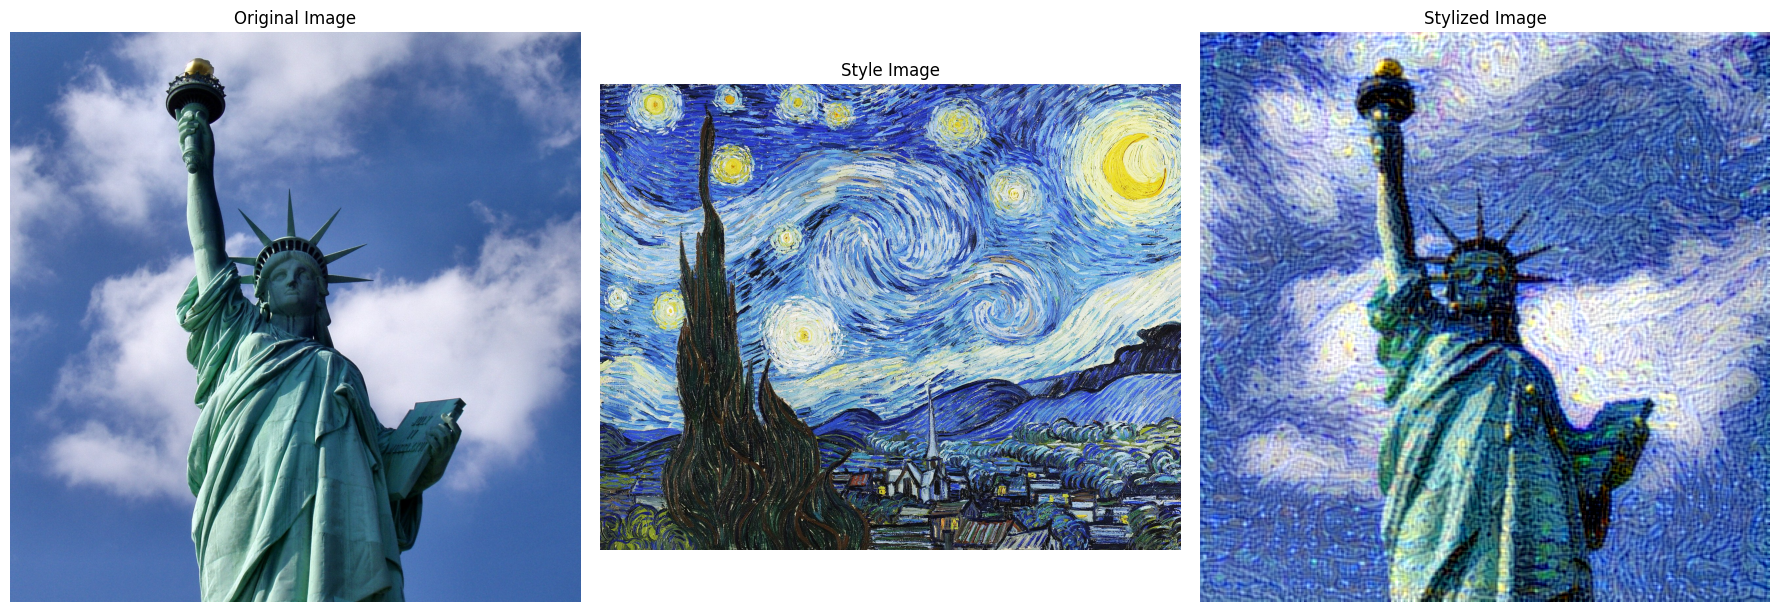

array([[[ 78, 114, 190],
        [ 78, 113, 193],
        [ 97, 134, 210],
        ...,
        [121, 119, 165],
        [105, 102, 152],
        [100, 105, 152]],

       [[ 58,  88, 184],
        [ 45,  73, 175],
        [ 57,  86, 185],
        ...,
        [131, 121, 185],
        [111,  98, 165],
        [116, 105, 166]],

       [[ 29,  56, 164],
        [  0,  19, 139],
        [  0,  14, 135],
        ...,
        [ 91,  77, 163],
        [ 71,  52, 143],
        [ 76,  57, 147]],

       ...,

       [[ 86, 117, 187],
        [ 79, 109, 179],
        [ 92, 124, 188],
        ...,
        [ 28,  72, 141],
        [ 51, 101, 162],
        [ 26,  76, 138]],

       [[ 86, 120, 186],
        [ 79, 111, 178],
        [ 88, 123, 185],
        ...,
        [ 44,  89, 154],
        [ 48,  95, 158],
        [ 26,  72, 140]],

       [[ 80, 114, 180],
        [ 67,  97, 169],
        [ 70, 104, 169],
        ...,
        [ 61, 105, 167],
        [ 62, 109, 171],
        [ 46,  93, 158]]

In [11]:
Run_StyleTransfer(
    base_image_path="/kaggle/input/styles-and-images/Styles and Images/Images/Liberty-statue.jpg",
    style_image_path="/kaggle/input/styles-and-images/Styles and Images/Styles/Style-8.jpg",
    result_prefix="Liberty_statue_generated",
    iterations=1000
)

Iteration 100: loss=11024.62
Iteration 200: loss=8519.05
Iteration 300: loss=7573.95
Iteration 400: loss=7063.44
Iteration 500: loss=6734.43
Iteration 600: loss=6499.20
Iteration 700: loss=6320.21
Iteration 800: loss=6178.08
Iteration 900: loss=6061.67
Iteration 1000: loss=5964.14
Final image saved to Liberty_statue_generated_final.png


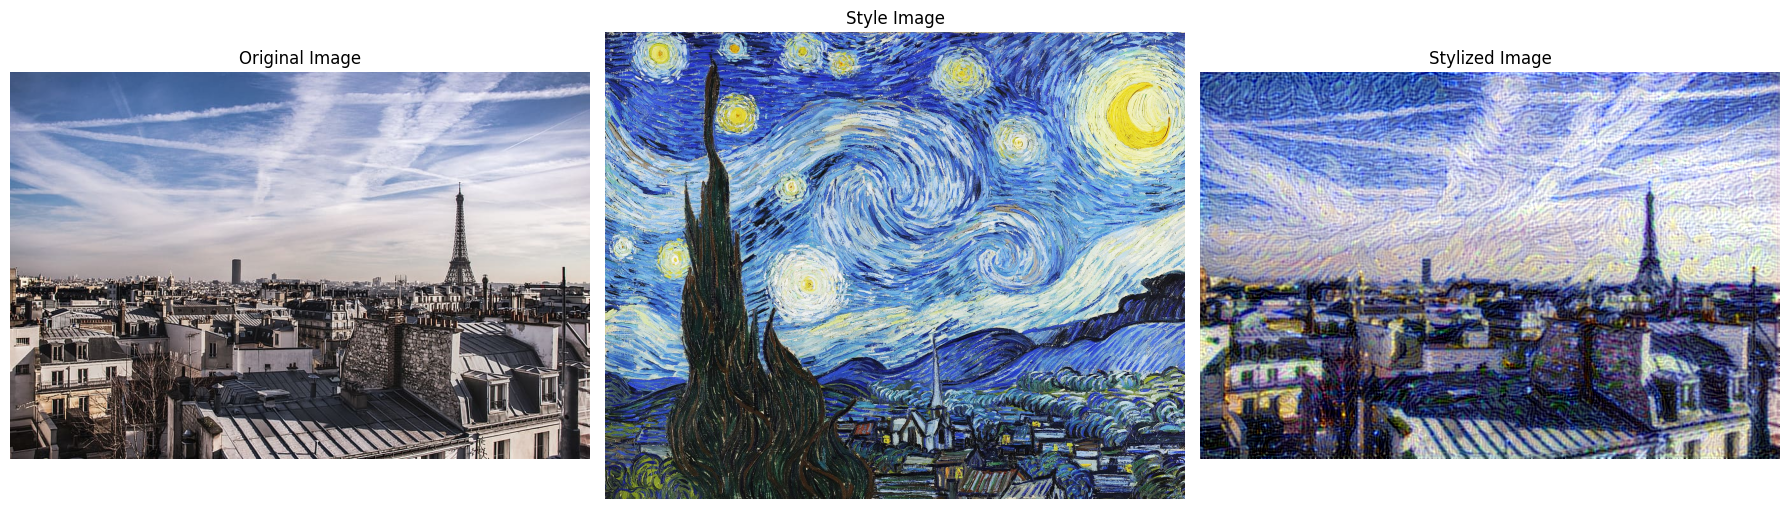

array([[[ 48,  61, 125],
        [ 41,  55, 123],
        [ 50,  64, 136],
        ...,
        [ 62,  74, 131],
        [ 76,  91, 139],
        [ 82, 100, 141]],

       [[ 42,  54, 124],
        [ 33,  49, 124],
        [ 46,  64, 143],
        ...,
        [ 69,  82, 141],
        [ 82,  97, 148],
        [ 92, 109, 154]],

       [[ 49,  64, 134],
        [ 41,  60, 135],
        [ 47,  71, 153],
        ...,
        [ 96, 112, 166],
        [ 93, 111, 159],
        [ 88, 106, 151]],

       ...,

       [[ 53,  56,  77],
        [ 28,  35,  62],
        [ 41,  54,  79],
        ...,
        [ 56,  63,  74],
        [ 45,  49,  59],
        [ 43,  42,  51]],

       [[ 42,  39,  61],
        [  5,   6,  36],
        [ 17,  24,  53],
        ...,
        [ 31,  33,  49],
        [ 41,  40,  50],
        [ 55,  53,  59]],

       [[ 62,  54,  71],
        [  0,   0,  20],
        [ 15,  15,  44],
        ...,
        [ 22,  18,  36],
        [ 43,  38,  48],
        [ 77,  72,  75]]

In [9]:
Run_StyleTransfer(
    base_image_path="/kaggle/input/styles-and-images/Styles and Images/Images/Paris.jpg",
    style_image_path="/kaggle/input/styles-and-images/Styles and Images/Styles/Style-8.jpg",
    result_prefix="Liberty_statue_generated",
    iterations=1000
)